# Architecture of a classification model

![arch-of-classification-model](../assets/arch-of-classification-model.png)

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [11]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [12]:
len(X), len(y)

(1000, 1000)

In [13]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [14]:
# Make DataFrame of circles
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

In [15]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [16]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

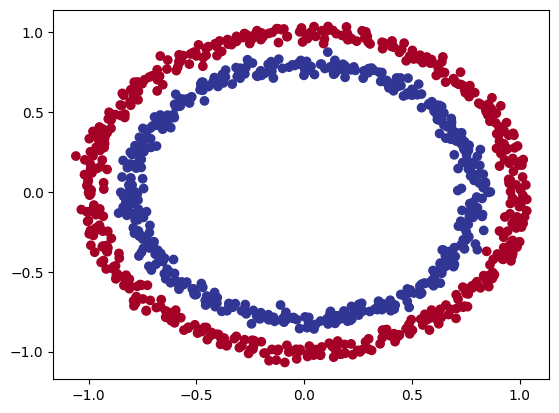

In [17]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: The data we're working with is ofter referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1. Check input and output shapes

In [18]:
X.shape, y.shape

((1000, 2), (1000,))

In [19]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2. Turn data into tensors and creat train and test splits

In [20]:
import torch
torch.__version__

'2.9.1+cu126'

In [21]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [22]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [23]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [24]:
torch.manual_seed(42)

In [25]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be trained 
                                                    random_state=42)

In [26]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [27]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [28]:
# Import PyTorch and nn
import torch
from torch import nn

# Make dvice agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outliens the forward pass (or forward computation) of the model
4. Instantiate an instance of the model class and send it to the target `device`

In [29]:
X_train.shape

torch.Size([800, 2])

In [83]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and outputs 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (sample shape as y)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
    
# 4. Instantiate an instance of the model class and send it to the target `device`
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [84]:
device

'cuda'

In [85]:
model_0.parameters()

<generator object Module.parameters at 0x0000026CF816D380>

In [86]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [87]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [88]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [89]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n First 10 predictions:\n {untrained_preds[:10]}")
print(f"\n First 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions:
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

 First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [90]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

### 2.1. Setup loss function and optimizer

Which loss function or optimizer should you use?

For classification might want binary cross entropy or categorical cross entropy (cross entropy)

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers
* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/
* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173
* For different optimizers see `torch.optim`

In [91]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through a Sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = Sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [92]:
# Calculate accuracy - Out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (gradient descent)

### 3.1. Going from raw logits -> prediction probabiliteis -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoide for binary classification and softmax for multiclass classification).

Then we can convert the model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [93]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [94]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

In [95]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For the prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y = 1 (class 1)
* `y_pred_probs` < 0.5, y = 0 (class 0)

In [96]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [97]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

### 3.2. Building a training and testing loop

In [98]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epoch
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Buil training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logts -> pred probs -> pred labels
    
    # 2. Calculate the loss / accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss() expects prediction probabilities as input
    #               y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        loss = loss_fn(test_logits,
                       y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69440, Train Acc: 51.88% | Test Loss: 0.69440, Test Acc: 58.00%
Epoch: 100 | Train Loss: 0.69271, Train Acc: 49.25% | Test Loss: 0.69271, Test Acc: 53.00%
Epoch: 200 | Train Loss: 0.69336, Train Acc: 50.88% | Test Loss: 0.69336, Test Acc: 49.00%
Epoch: 300 | Train Loss: 0.69376, Train Acc: 51.12% | Test Loss: 0.69376, Test Acc: 46.50%
Epoch: 400 | Train Loss: 0.69403, Train Acc: 51.25% | Test Loss: 0.69403, Test Acc: 47.50%
Epoch: 500 | Train Loss: 0.69423, Train Acc: 50.88% | Test Loss: 0.69423, Test Acc: 47.00%
Epoch: 600 | Train Loss: 0.69436, Train Acc: 51.25% | Test Loss: 0.69436, Test Acc: 46.50%
Epoch: 700 | Train Loss: 0.69446, Train Acc: 51.25% | Test Loss: 0.69446, Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69453, Train Acc: 51.50% | Test Loss: 0.69453, Test Acc: 45.50%
Epoch: 900 | Train Loss: 0.69458, Train Acc: 51.38% | Test Loss: 0.69458, Test Acc: 45.00%


## 4. Make predictions and evaluate the model

From the metrics, it looks like the model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [99]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)
    print("Download complete!")
        
from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download.


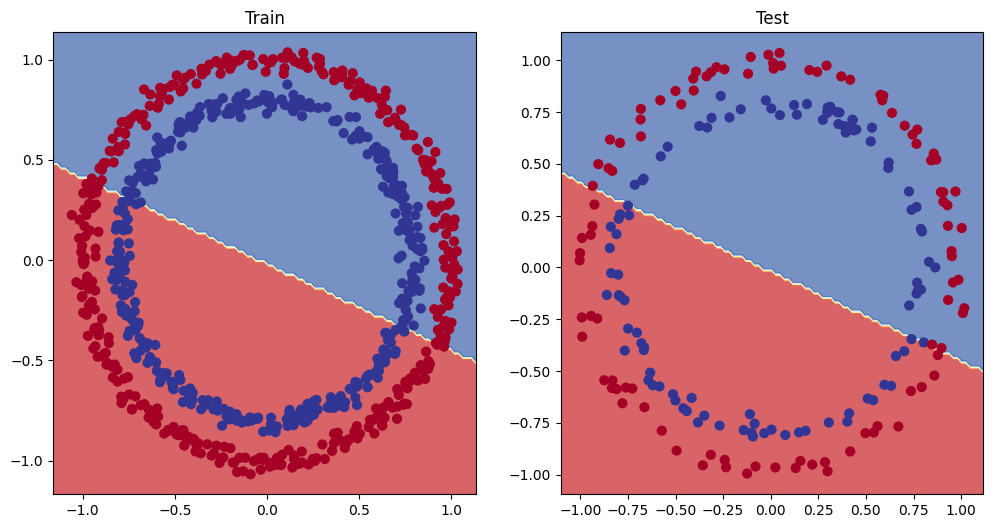

In [100]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden untis to 10 hidden untis
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These optiops are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as amachine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve the model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [101]:
class CirclemodelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
    
model_1 = CirclemodelV1().to(device)
model_1

CirclemodelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [102]:
# Create a loss function
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through a Sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = Sigmoid activation function built-in
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [103]:
# Write a training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epoch
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Buil training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logts -> pred probs -> pred labels
    
    # 2. Calculate the loss / accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss() expects prediction probabilities as input
    #               y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                       y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305, Train Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299, Train Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298, Train Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298, Train Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


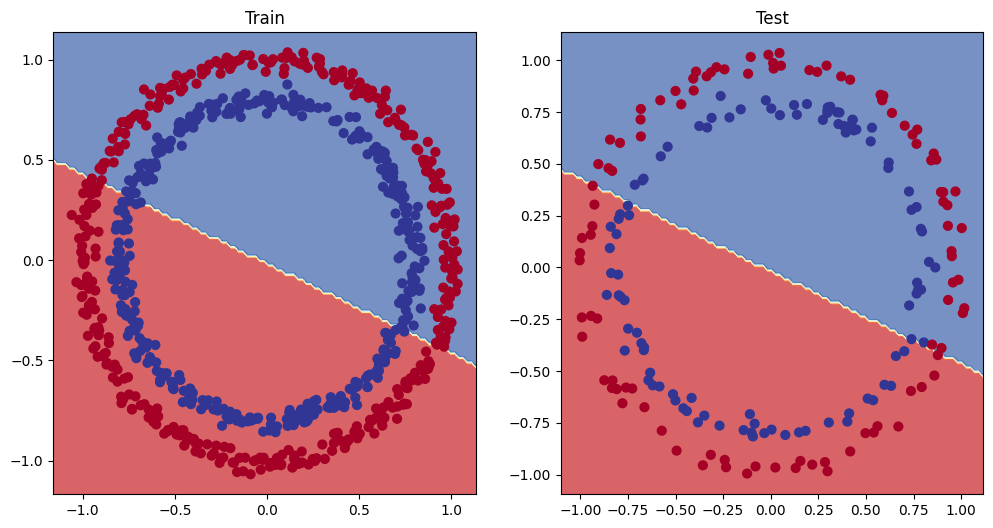

In [104]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1. Preparing data to see if the model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [105]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [106]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

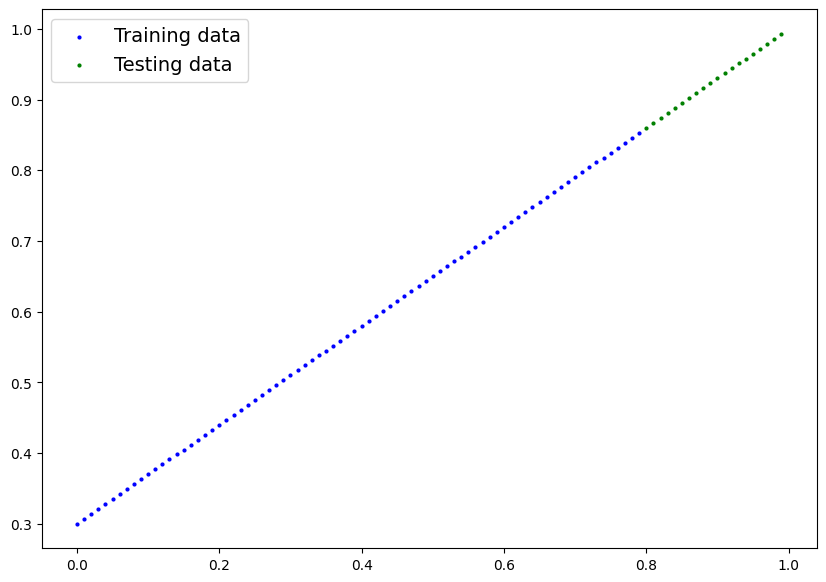

In [107]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [108]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2. Adjusting `model_1` to fit a straight line

In [109]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [110]:
# Loss and optimizer
loss_fn = nn.L1Loss()
opimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.01)

In [111]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epoch
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    opimizer.zero_grad()
    loss.backward()
    opimizer.step()
    
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Train Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Train Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Train Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Train Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Train Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Train Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Train Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Train Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Train Loss: 0.01798 | Test Loss: 0.00360


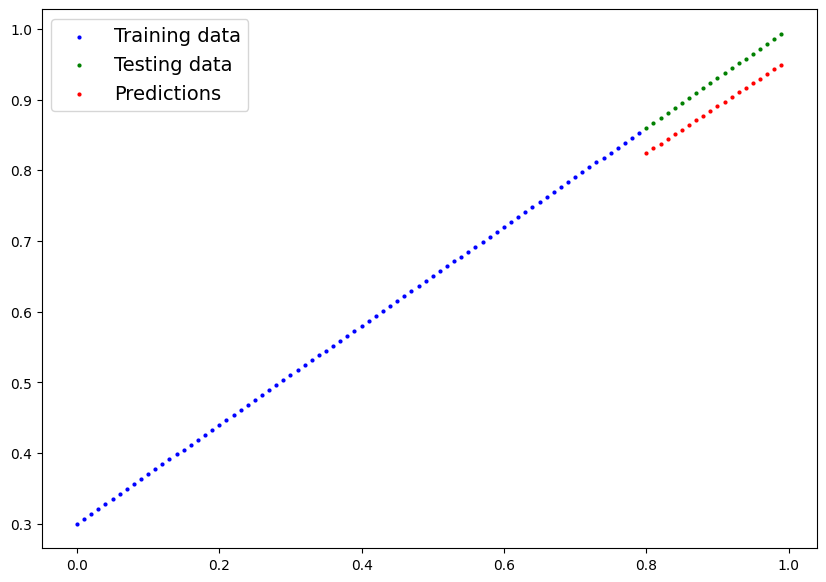

In [112]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: Non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1. Recreating non-linear data (red and blue circles)

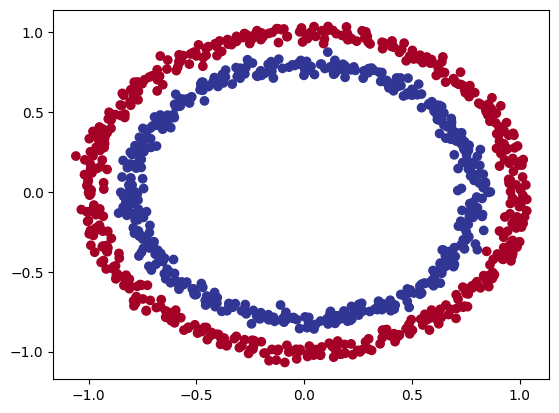

In [113]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [114]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2. Building a model with non-linearity

* Linear = straight lines
* Non-linear = non straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to dind patterns in data

In [115]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function
        
    def forward(self, x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        
        
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [116]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [117]:
# Spam or not spam
# Credit cards = fraud or not fraud
# Insurance claims = at fault or not fault

### 6.3. Training a model with non-linearity

In [125]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Buil training and evaluation loop
for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.0050, Train Acc: 100.00% | Test Loss: 0.0156 | Test Acc: 99.50%
Epoch: 100 | Train Loss: 0.0049, Train Acc: 100.00% | Test Loss: 0.0155 | Test Acc: 99.50%
Epoch: 200 | Train Loss: 0.0048, Train Acc: 100.00% | Test Loss: 0.0153 | Test Acc: 99.50%
Epoch: 300 | Train Loss: 0.0048, Train Acc: 100.00% | Test Loss: 0.0152 | Test Acc: 99.50%
Epoch: 400 | Train Loss: 0.0047, Train Acc: 100.00% | Test Loss: 0.0151 | Test Acc: 99.50%
Epoch: 500 | Train Loss: 0.0046, Train Acc: 100.00% | Test Loss: 0.0150 | Test Acc: 99.50%
Epoch: 600 | Train Loss: 0.0045, Train Acc: 100.00% | Test Loss: 0.0149 | Test Acc: 99.50%
Epoch: 700 | Train Loss: 0.0045, Train Acc: 100.00% | Test Loss: 0.0148 | Test Acc: 99.50%
Epoch: 800 | Train Loss: 0.0044, Train Acc: 100.00% | Test Loss: 0.0147 | Test Acc: 99.50%
Epoch: 900 | Train Loss: 0.0043, Train Acc: 100.00% | Test Loss: 0.0146 | Test Acc: 99.50%


### 6.4. Evaluating a model trained with non-linear activation functions

In [126]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))
    
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

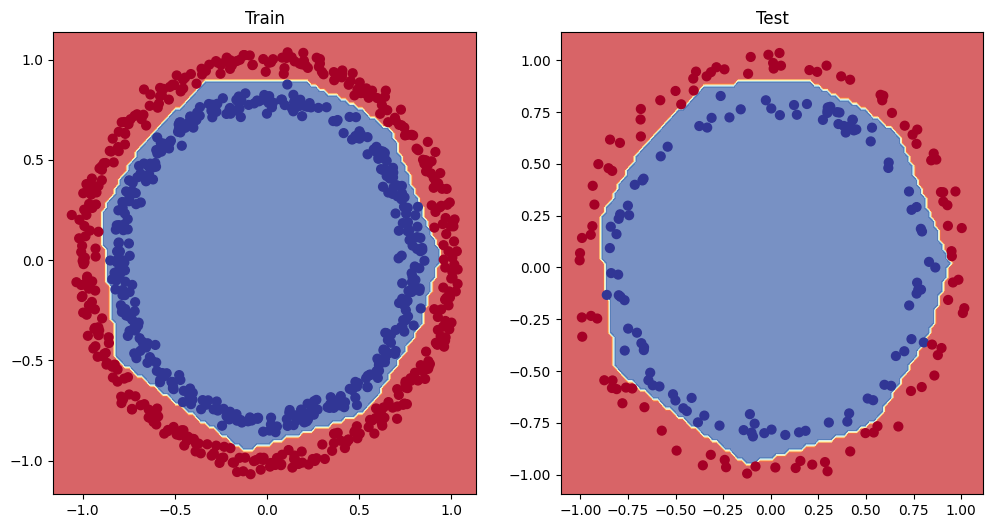

In [127]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [128]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [129]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

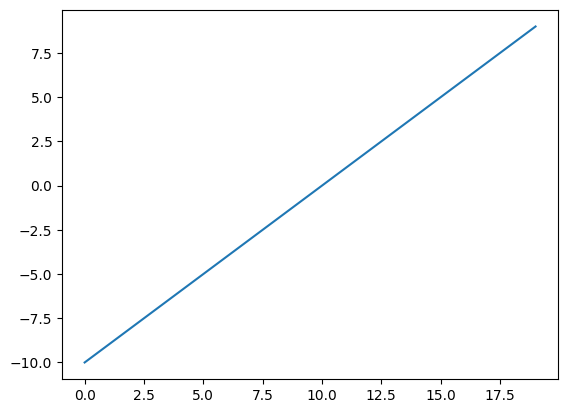

In [130]:
# Visualize the tensor
plt.plot(A)

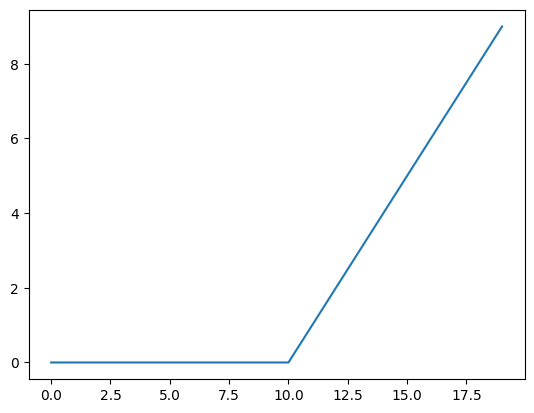

In [131]:
plt.plot(torch.relu(A))

In [132]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

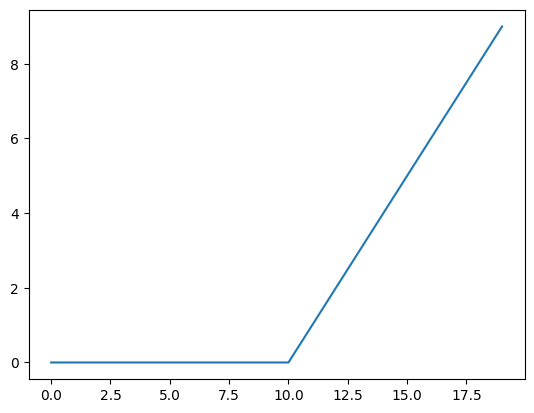

In [133]:
# Plot ReLU activation function
plt.plot(relu(A))

In [134]:
# Now let's do the same for Sigmoid activation function
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

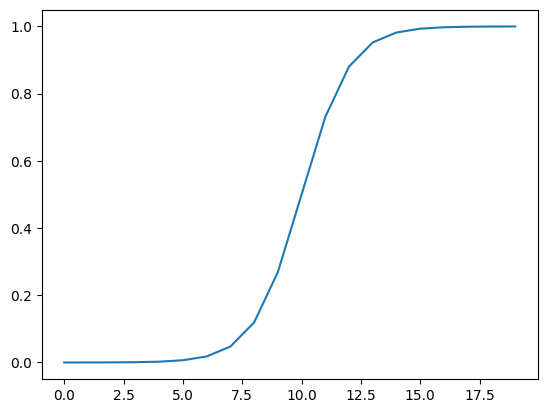

In [135]:
plt.plot(torch.sigmoid(A))

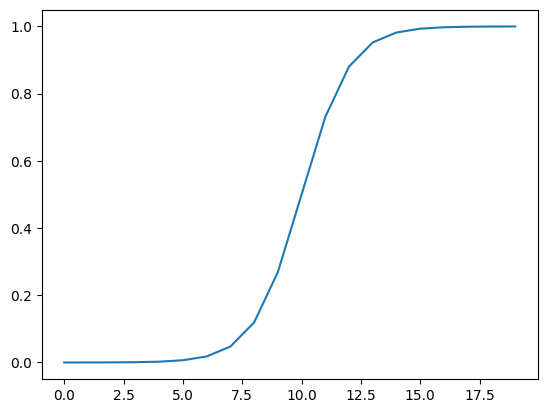

In [136]:
plt.plot(sigmoid(A))